In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import torch
import torch.nn as nn
import torch.optim as optim


In [23]:
# 从 Excel 文件读取数据
df = pd.read_excel('仿真数据.xlsx')

# 提取列数据
u1_data = df['u1'].values
u2_data = df['u2'].values
y1_data = df['y1'].values
y2_data = df['y2'].values

# # 输出提取的数据
# print('u1_data:', u1_data.shape)
# print('u2_data:', u2_data.shape)
# print('y1_data:', y1_data.shape)
# print('y2_data:', y1_data.shape)

num_samples = y1_data.shape[0]


In [24]:
# 组合训练数据  多输入双输出
# 假设有训练数据 u1_data, u2_data, y1_data 和 y1_data+1
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
# 1 |2| 3 4 5 6 
# 6 |1| 2 3 4 5
# 1 |2| 3 4 5 6 

u1_data = u1_data
u2_data = u2_data

u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0

y1_data = y1_data
y2_data = y2_data

X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1],
                        u1_data_1[1:-1], u2_data_1[1:-1],
                        y1_data  [1:-1], y2_data  [1:-1])
                    )
y = np.column_stack((y1_data[2:],y2_data[2:]))

# 使用 reshape 转换形状
X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
y_reshaped = y.reshape((y.shape[0], 1, y.shape[1]))

print(X.shape,y.shape)
print(X_reshaped.shape,y_reshaped.shape)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.3333333, random_state=42)
y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(300, 6) (300, 2)
(300, 1, 6) (300, 1, 2)
(200, 1, 6) (200, 2)
(100, 1, 6) (100, 2)


In [25]:
import torch
import torch.nn.functional as F
import torch.optim as optim

class MyCustomLSTM:
    def __init__(self, input_size, hidden_size, output_size):
        # 初始化权重和偏置
        self.w_ii = torch.randn(hidden_size, input_size, requires_grad=True)
        self.w_hi = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.b_ii = torch.zeros(hidden_size, requires_grad=True)
        self.b_hi = torch.zeros(hidden_size, requires_grad=True)

        self.w_io = torch.randn(hidden_size, input_size, requires_grad=True)
        self.w_ho = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.b_io = torch.zeros(hidden_size, requires_grad=True)
        self.b_ho = torch.zeros(hidden_size, requires_grad=True)

        self.w_if = torch.randn(hidden_size, input_size, requires_grad=True)
        self.w_hf = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.b_if = torch.zeros(hidden_size, requires_grad=True)
        self.b_hf = torch.zeros(hidden_size, requires_grad=True)

        self.w_ig = torch.randn(hidden_size, input_size, requires_grad=True)
        self.w_hg = torch.randn(hidden_size, hidden_size, requires_grad=True)
        self.b_ig = torch.zeros(hidden_size, requires_grad=True)
        self.b_hg = torch.zeros(hidden_size, requires_grad=True)

        # 输出层权重和偏置
        self.w_out = torch.randn(output_size, hidden_size, requires_grad=True)
        self.b_out = torch.zeros(output_size, requires_grad=True)

        # 保存中间状态
        self.hidden_state = None
        self.cell_state = None
        self.hidden_size = hidden_size

    def get_self_params(self):
        return (self.w_ii.detach().numpy(),
                self.w_hi.detach().numpy(),
                self.b_ii.detach().numpy(),
                self.b_hi.detach().numpy(),
                self.w_io.detach().numpy(),
                self.w_ho.detach().numpy(),
                self.b_io.detach().numpy(),
                self.b_ho.detach().numpy(),
                self.w_if.detach().numpy(),
                self.w_hf.detach().numpy(),
                self.b_if.detach().numpy(),
                self.b_hf.detach().numpy(),
                self.w_ig.detach().numpy(),
                self.w_hg.detach().numpy(),
                self.b_ig.detach().numpy(),
                self.b_hg.detach().numpy(),
                self.w_out.detach().numpy(),
                self.b_out.detach().numpy(),
                self.hidden_size)
    
    def linear(self, x, weight, bias):
        return torch.matmul(x, weight.t()) + bias

    def lstm_step(self, input_data):
        # 输入门
        i_t = torch.sigmoid(self.linear(input_data, self.w_ii, self.b_ii) + self.linear(self.hidden_state, self.w_hi, self.b_hi))
        
        # 输出门
        o_t = torch.sigmoid(self.linear(input_data, self.w_io, self.b_io) + self.linear(self.hidden_state, self.w_ho, self.b_ho))
        
        # 遗忘门
        f_t = torch.sigmoid(self.linear(input_data, self.w_if, self.b_if) + self.linear(self.hidden_state, self.w_hf, self.b_hf))
        
        # 计算新单元状态
        g_t = torch.tanh(self.linear(input_data, self.w_ig, self.b_ig) + self.linear(self.hidden_state, self.w_hg, self.b_hg))
        self.cell_state = f_t * self.cell_state + i_t * g_t

        # 更新隐藏状态
        self.hidden_state = o_t * torch.tanh(self.cell_state)
    

    def forward(self, input_data):
        # print(self.w_ii.size(0))
        # [1,1,6]
        # 初始化隐藏状态和单元状态
        self.hidden_state = torch.zeros(input_data.size(0), self.w_ii.size(0))
        self.cell_state = torch.zeros(input_data.size(0), self.w_ii.size(0))
        # 遍历时间步
        for t in range(input_data.size(1)):
            # 获取当前时间步的输入
            x_t = input_data[:, t, :]
            
            # 运行LSTM单元
            self.lstm_step(x_t)
        # 最终输出
        output = self.linear(self.hidden_state, self.w_out, self.b_out)
        return output

    def custom_loss(self, y_true, y_pred):
        y_pred.requires_grad_(True)

        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse

    def my_fit(self, X_train, y_train, epochs=1, lr=0.001, batch_size = 32):
        optimizer = optim.Adam([self.w_ii, self.w_hi, self.b_ii, self.b_hi,
                                self.w_io, self.w_ho, self.b_io, self.b_ho,
                                self.w_if, self.w_hf, self.b_if, self.b_hf,
                                self.w_ig, self.w_hg, self.b_ig, self.b_hg,
                                self.w_out, self.b_out], lr=lr)
        loss_list = []

        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self.forward(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                # print("Gradient of w_ii:", self.w_ii.grad)
                # print("Gradient of w_hi:", self.w_hi.grad)
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_loss = epoch_loss / (len(X_train) // batch_size + 1)
            print(f'第 {epoch + 1}/{epochs} 轮, 误差: {average_epoch_loss:.4f}', end='\r')
            loss_list.append(average_epoch_loss)

        return loss_list

    

    def my_predict_with_no_grad(self, X_test):
        x_batch = torch.tensor(X_test, dtype=torch.float32)
        output = self.forward(x_batch)
        return output[:,0].detach().numpy(),output[:,1].detach().numpy()




In [26]:
# 实例化模型
model = MyCustomLSTM(input_size=6, hidden_size=32, output_size=2)
epoch_sum = 0
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(200, 1, 6) (200, 2)
(100, 1, 6) (100, 2)


In [60]:
# 自定义预测
def custom_sigmoid(x):
    return 1 / (1 + np.exp(-x))
def linear_numpy(x, weight, bias):
    return np.matmul(x, np.transpose(weight)) + bias

def my_lstm_step(x_t,w_ii,w_hi,b_ii,b_hi,w_io,w_ho,b_io,
                b_ho,w_if,w_hf,b_if,b_hf,w_ig,w_hg,
                b_ig,b_hg,w_out,b_out,hidden_size,cell_state,hidden_state):
        # print('x_t.shape',x_t.shape)
        # print('shape',w_ii.shape,w_hi.shape,b_ii.shape,b_hi.shape,)
        # print('shape',w_io.shape,w_ho.shape,b_io.shape,b_ho.shape,)
        # print('shape',w_if.shape,w_hf.shape,b_if.shape,b_hf.shape,)
        # print('shape',w_ig.shape,w_hg.shape,b_ig.shape,b_hg.shape,)
        # print('shape',cell_state.shape,hidden_state.shape,)

        # 输入门
        i_t = custom_sigmoid(linear_numpy(x_t, w_ii, b_ii) + linear_numpy(hidden_state, w_hi, b_hi))
        
        # 输出门
        o_t = custom_sigmoid(linear_numpy(x_t, w_io, b_io) + linear_numpy(hidden_state, w_ho, b_ho))
        
        # 遗忘门
        f_t = custom_sigmoid(linear_numpy(x_t, w_if, b_if) + linear_numpy(hidden_state, w_hf, b_hf))
        
        # 计算新单元状态
        g_t = np.tanh(linear_numpy(x_t, w_ig, b_ig) + linear_numpy(hidden_state, w_hg, b_hg))
        cell_state = f_t * cell_state + i_t * g_t

        # 更新隐藏状态
        hidden_state = o_t * np.tanh(cell_state)

        
        return cell_state,hidden_state
def my_predict_with_no_grad(X_test):
        x_batch = X_test
        
        (w_ii,w_hi,b_ii,b_hi,w_io,w_ho,b_io,
        b_ho,w_if,w_hf,b_if,b_hf,w_ig,w_hg,
        b_ig,b_hg,w_out,b_out,hidden_size) = model.get_self_params()
        
        # 初始化隐藏状态和单元状态
        # print(hidden_size)
        hidden_state = np.zeros((1, hidden_size))
        cell_state = np.zeros((1, hidden_size))
        
        # 遍历时间步
        for t in range(1):
            # 获取当前时间步的输入
            print(x_batch.shape)
            x_t = x_batch[:, t, :]
            # print('fghjk')
            # 运行LSTM单元
            cell_state,hidden_state = my_lstm_step(x_t,w_ii,w_hi,b_ii,b_hi,w_io,w_ho,b_io,
                            b_ho,w_if,w_hf,b_if,b_hf,w_ig,w_hg,
                            b_ig,b_hg,w_out,b_out,hidden_size,
                            cell_state,hidden_state)
        # 最终输出
        output = linear_numpy(hidden_state, w_out, b_out)
        
        return output[:,0],output[:,1]


In [61]:
y_pred_0,y_pred_1  = my_predict_with_no_grad(X_test)


(100, 1, 6)


In [62]:
# # 训练-预测-RMSE、MRE、画出误差的概率密度函数
epoch_once = 300
epoch_sum = epoch_sum+epoch_once
loss_history = model.my_fit(X_train, y_train, epochs=epoch_once, batch_size=32)
y_pred_0,y_pred_1  = model.my_predict_with_no_grad(X_test)

# 计算 RMSE、MRE、画出误差的概率密度函数
# print(y_pred.shape)
print('\nepoch_sum:',epoch_sum)
y_test = y_test
rmse_0 = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_0))
rmse_1 = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_1))

# 计算 
mre_0 = np.mean(np.abs((y_test[:, 0] - y_pred_0) / y_test[:, 0])) * 100
mre_1 = np.mean(np.abs((y_test[:, 1] - y_pred_1) / y_test[:, 1])) * 100

# 打印结果
print("Dimension 0:")
print("RMSE:", rmse_0)
print("MRE:", mre_0)

print("\nDimension 1:")
print("RMSE:", rmse_1)
print("MRE:", mre_1)


第 300/300 轮, 误差: 0.0051
epoch_sum: 600
Dimension 0:
RMSE: 0.20075649643245588
MRE: 36.31619713808396

Dimension 1:
RMSE: 0.21518713822300464
MRE: 54.059135536500754


Dimension 0:
RMSE: 0.20075649643245588
MRE: 36.31619713808396

Dimension 1:
RMSE: 0.21518713822300464
MRE: 54.059135536500754


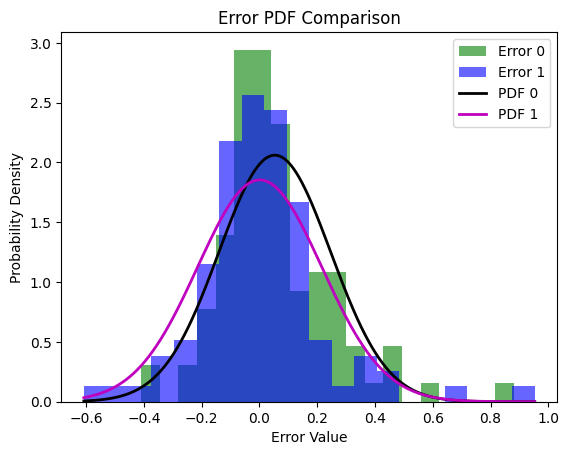

In [63]:
# 计算 RMSE、MRE、画出误差的概率密度函数
y_test = y_test
rmse_0 = np.sqrt(mean_squared_error(y_test[:, 0], y_pred_0))
rmse_1 = np.sqrt(mean_squared_error(y_test[:, 1], y_pred_1))

# 计算 
mre_0 = np.mean(np.abs((y_test[:, 0] - y_pred_0) / y_test[:, 0])) * 100
mre_1 = np.mean(np.abs((y_test[:, 1] - y_pred_1) / y_test[:, 1])) * 100

# 打印结果
print("Dimension 0:")
print("RMSE:", rmse_0)
print("MRE:", mre_0)

print("\nDimension 1:")
print("RMSE:", rmse_1)
print("MRE:", mre_1)

# 假设 error0 和 error1 是你的误差数据，这里使用随机生成的数据作为示例
error0 = y_test[:, 0]-y_pred_0
error1 = y_test[:, 1]-y_pred_1

# 计算误差的概率密度函数
plt.hist(error0, bins=20, density=True, alpha=0.6, color='g', label='Error 0')
plt.hist(error1, bins=20, density=True, alpha=0.6, color='b', label='Error 1')

# 生成 PDF 的 x 值范围
x_range = np.linspace(min(min(error0), min(error1)), max(max(error0), max(error1)), 10000)

# 计算正态分布的概率密度函数
pdf_values0 = 1/(np.sqrt(2*np.pi)*np.std(error0)) * np.exp(-(x_range-np.mean(error0))**2/(2*np.std(error0)**2))
pdf_values1 = 1/(np.sqrt(2*np.pi)*np.std(error1)) * np.exp(-(x_range-np.mean(error1))**2/(2*np.std(error1)**2))

# 绘制正态分布的概率密度函数
plt.plot(x_range, pdf_values0, 'k-', linewidth=2, label='PDF 0')
plt.plot(x_range, pdf_values1, 'm-', linewidth=2, label='PDF 1')

plt.legend()
plt.xlabel('Error Value')
plt.ylabel('Probability Density')
plt.title('Error PDF Comparison')
plt.show()



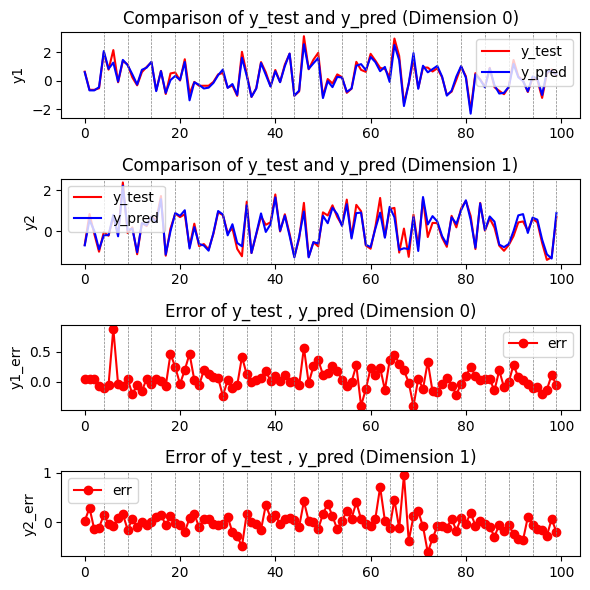

In [64]:
# 预测结果及误差
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(6, 6))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(y_test[:, 0], 'r-', label='y_test')
plt.plot(y_pred_0, 'b-', label='y_pred')

plt.ylabel('y1')
plt.title('Comparison of y_test and y_pred (Dimension 0)')
plt.legend()

# 在每隔五个样本的位置画竖直虚线
for i in range(4, len(y_test), 5):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(y_test[:, 1], 'r-', label='y_test')
plt.plot(y_pred_1, 'b-', label='y_pred')

plt.ylabel('y2')
plt.title('Comparison of y_test and y_pred (Dimension 1)')
plt.legend()

# 在每隔五个样本的位置画竖直虚线
for i in range(4, len(y_test), 5):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

# 第一个维度的曲线
plt.subplot(4, 1, 3)
plt.plot(y_test[:, 0]-y_pred_0, 'ro-', label='err')

plt.ylabel('y1_err')
plt.title('Error of y_test , y_pred (Dimension 0)')
plt.legend()

# 在每隔五个样本的位置画竖直虚线
for i in range(4, len(y_test), 5):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

# 第二个维度的曲线
plt.subplot(4, 1, 4)
plt.plot(y_test[:, 1]-y_pred_1, 'ro-', label='err')

plt.ylabel('y2_err')
plt.title('Error of y_test , y_pred (Dimension 1)')
plt.legend()

# 在每隔五个样本的位置画竖直虚线
for i in range(4, len(y_test), 5):
    plt.axvline(x=i, color='gray', linestyle='--', linewidth=0.5)

# 调整子图布局
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


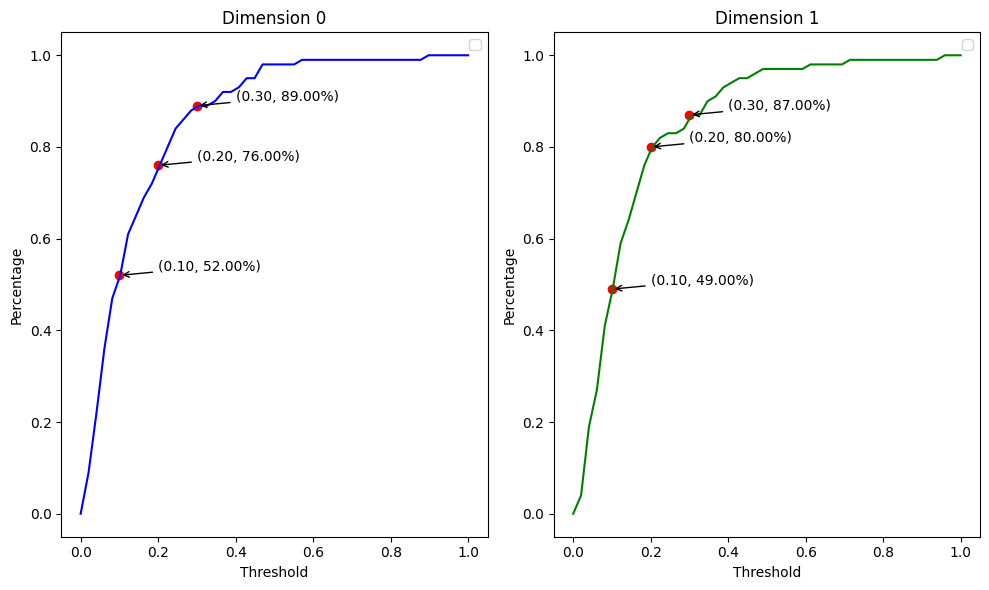

In [65]:
# 预测结构命中率曲线
import matplotlib.pyplot as plt
import numpy as np

# 计算 error0 和 error1 的绝对值小于阈值的比例
thresholds = np.linspace(0, 1, 50)  # 设置不同的阈值
below_threshold_percentages_0 = []
below_threshold_percentages_1 = []

for threshold in thresholds:
    error0_abs = np.abs(y_test[:, 0] - y_pred_0)
    below_threshold_percentage_0 = np.mean(error0_abs < threshold)
    below_threshold_percentages_0.append(below_threshold_percentage_0)

    error1_abs = np.abs(y_test[:, 1] - y_pred_1)
    below_threshold_percentage_1 = np.mean(error1_abs < threshold)
    below_threshold_percentages_1.append(below_threshold_percentage_1)

# 找到几个关键点的坐标
key_points_thresholds = [0.1, 0.2, 0.3]
key_points_percentages_0 = [below_threshold_percentages_0[np.argmin(np.abs(thresholds - t))] for t in key_points_thresholds]
key_points_percentages_1 = [below_threshold_percentages_1[np.argmin(np.abs(thresholds - t))] for t in key_points_thresholds]

# 绘制两个子图
plt.figure(figsize=(10, 6))

# 第一个子图，绘制 error0
plt.subplot(1, 2, 1)
plt.plot(thresholds, below_threshold_percentages_0, 'b-')
plt.scatter(key_points_thresholds, key_points_percentages_0, color='red', marker='o')  # 添加关键点

# 添加关键点的标签并调整位置
for threshold, percentage in zip(key_points_thresholds, key_points_percentages_0):
    plt.annotate(f'({threshold:.2f}, {percentage:.2%})', xy=(threshold, percentage), xytext=(threshold + 0.1, percentage + 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Dimension 0')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend()

# 第二个子图，绘制 error1
plt.subplot(1, 2, 2)
plt.plot(thresholds, below_threshold_percentages_1, 'g-')
plt.scatter(key_points_thresholds, key_points_percentages_1, color='red', marker='o')  # 添加关键点

# 添加关键点的标签并调整位置
for threshold, percentage in zip(key_points_thresholds, key_points_percentages_1):
    plt.annotate(f'({threshold:.2f}, {percentage:.2%})', xy=(threshold, percentage), xytext=(threshold + 0.1, percentage + 0.01),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.title('Dimension 1')
plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.legend()

# 调整子图布局
plt.tight_layout()
plt.show()



In [66]:
# 差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.001
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1
    # return output1 + noise1, output2 + noise2
    return output1 + noise1, output2 + noise2 ,noise1 ,noise2
    # return output1, output2,noise1,noise2


In [67]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):
    set_y1 = np.full(Times, 0.4)
    set_y1[40:] = 0.6
    # set_y1[90:] = -0.1
    # set_y1[130:151] = 0.0
    # set_y1[170:201] = 0.4
    # set_y1[185] = -0.7  # 添加脉冲干扰

    set_y2 = np.full(Times, 0.2)
    set_y2[70:] = 0.3
    # set_y2[90:] = 0.5
    # set_y2[150:] = -0.7  # 添加脉冲干扰
    # set_y2[200:] = 0.4

    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)

    return set_y1, set_y2



# # 调用示例
# set_y1, set_y2 = generate_y_aim_data(Times)
# plt.plot(set_y1)
# plt.plot(set_y2)
# plt.title('y_sp')
# plt.show()



In [68]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
# y_r = get_yr(1,-0.5,0.1,5+1)


In [69]:
#生成控制时域的数据格式
def generate_k_data(u1_data, u2_data, y1_data, num_samples, P):
    # 生成随机索引值
    #从原有数据的randint时刻开始往下进行控制
    randint = np.random.randint(1, num_samples - 2 - P - 1)
    randint = 181  # 如果你希望使用固定的值而不是随机生成
    # randint = 250  # 如果你希望使用固定的值而不是随机生成
    print(randint)
    # 提取数据并构成 k_data
    # 第一次得到下面五个变量，固定好格式构成k_data
    u1   = u1_data[randint  :randint+2  ]
    u2   = u2_data[randint  :randint+2  ]
    u1_1 = u1_data[randint-1:randint+2-1]
    u2_1 = u2_data[randint-1:randint+2-1]
    y1   = y1_data[randint  :randint+2  ]
    y2   = y2_data[randint  :randint+2  ]
    k_data = np.concatenate((u1, u2, u1_1, u2_1, y1, y2), axis=0)
    # print(k_data.shape)

    k_data = np.zeros_like(k_data)
    return k_data



In [70]:
def exponential_decay_weights(length, decay_factor=0.9):
    """
    生成指数衰减的权重数组。

    Parameters:
    - length: 权重数组的长度
    - decay_factor: 衰减因子，控制权重的衰减速度

    Returns:
    - weights: 生成的权重数组
    """
    weights = np.power(decay_factor, np.arange(length))
    weights /= np.sum(weights)  # 归一化确保权重之和为1
    return weights
def loss_function(original_sequence, simulated_sequence, weights):
    """
    计算原始序列和仿真预测序列的加权误差损失函数。

    Parameters:
    - original_sequence: 原始序列
    - simulated_sequence: 仿真预测序列
    - weights: 用于加权的权重数组

    Returns:
    - weighted_loss: 加权误差损失
    """
    error = original_sequence - simulated_sequence
    weighted_loss = np.dot(weights, np.square(error))
    return weighted_loss


In [71]:
# 原有   定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim):
    # 从固定格式k_data里面读取信息
    u1   = k_data[0:2]
    u2   = k_data[2:4]
    u1_1 = k_data[4:6]
    u2_1 = k_data[6:8]
    y1   = k_data[8:10]
    y2   = k_data[10:12]
    # 获取猜测值[h U1 U2]
    # h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    U1, U2  =params[0:M], params[M:2*M]
    h = 1.0
    # 整理数据见   MPC推到.escel
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    y1   = np.concatenate((y1,np.zeros(P)))
    y2   = np.concatenate((y2,np.zeros(P)))
    y1_k = y1[1]
    y2_k = y2[1]
    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)
    # 生成指数衰减的权重
    weights = exponential_decay_weights(P, decay_factor=0.67)

    # 总共预测 P+1 次
    # 对k时刻进行预测-----1次
    for j in range(1):
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_m_k,y2_m_k = my_predict_with_no_grad(x)
        # y1[j+1] = y1_m_k.item()###############################是否替换不知道有没有影响？
        # y2[j+1] = y2_m_k.item()###############################
        # 在k时刻，我要先通过k-1时刻来预测出当前k时刻下的预测值。
        # 实际上，这个时候我有k时刻的真实值。
        # 但是这么做是为了能够获取我的预测值和真实值之间的误差，
        # 然后基于这个误差，通过对控制器输入的调整来预测k+1时刻，
        # 然后依次往下。因此，在k时刻，我系统的值是固定的，
        # 也就是我的真实值，所以我要把它存储到我的整体的一个序列里面。
        # 在取出当前k时刻真实值的过程中，我不能将之前预测的时候的那个
        # 预测值覆盖掉真实值。后面新预测的数值要加上前面的那一个误差
        E1_k = y1_k - y1_m_k
        E2_k = y2_k - y2_m_k

    # 对每个U对应的控制时刻进行预测-----M次
    for j in range(1,M+1):  
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = my_predict_with_no_grad(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # 对控制时域外的部分进行预测-----P-M次
    # 注意：这部分的信号是保持控制不变下进行
    for j in range(M+1,P+1):
        x = np.column_stack((u1[-1],u2[-1],u1[-1],u2[-1],y1[j],y2[j]))
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        y1_k_j,y2_k_j = my_predict_with_no_grad(x)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+1] = y2_k_j.item()

    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)
    # print(y2)
    # print(y1_k)    
    # print(y2_k)
    # print('2222222222222222222')
        

    #和获取参考轨迹
    # 一定要对照好做差的序列
    y_r  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y_r[1:] 
    # print('y1_aim',y1_aim)
    # print('y_r',y_r)


    y_r  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y_r[1:] 
    # print('y2_aim',y2_aim)
    # print('y_r',y_r)

    y1_M_k = y1[2:]
    y2_M_k = y2[2:]
    # print('y1',y1)
    # print('h*E1_k',h*E1_k)
    # print('y2',y2)
    # print('h*E2_k',h*E2_k)



    # 计算mse
    # lamda1太大的话会导致y1_r和y1_M_k的误差加大*****************导致超调的原因\与目标值之间存在间隙
    lamda1 = 0.0
    lamda2 = 0.0
    if np.abs(y1_aim-y1_k)<0.0001 and np.abs(y2_aim-y2_k)<0.0001:
        lamda1 = 1
        lamda2 = 1
    mse = (0
            # +loss_function(y1_r, y1_M_k+h*E1_k, weights)
            # +loss_function(y2_r, y2_M_k+h*E2_k, weights)
            # +(np.abs(y1_aim-y1_k)**2+np.abs(y2_aim-y2_k)**2)*P*2000
            +np.sum((y1_r-y1_M_k-h*E1_k)**2 + (y2_r-y2_M_k-h*E2_k)**2)
            # +np.sum(lamda1*(np.diff(u1)**2))
            # +np.sum(lamda2*(np.diff(u2)**2))


            )

    k_data2 = np.concatenate((u1[1:3],u2[1:3],u1_1[1:3],u2_1[1:3],y1[1:3],y2[1:3]),axis=0)

    return mse , k_data2


In [72]:
# 原有   对未来Times周期预测控制
# 期望设定值
set_y1 , set_y2 = generate_y_aim_data(Times)
# MPC参数
P = 3  # 预测时域长度
M = 2  # 控制时域长度
#生成控制时域的数据格式
k_data = generate_k_data(u1_data, u2_data, y1_data, num_samples, P)

# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_noise1  = []
all_pred_noise2 = []
# all_pred_y1.append(y1_data[1])
# all_pred_y2.append(y2_data[1])
# MPC控制循环
for k in range(Times):
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2 = my_MPC(k_data=k_data[0], params=params, M=M, P=P, y1_aim = set_y1[k], y2_aim = set_y2[k])  
        return mse

    # # 初始猜测值[h U1 U2]
    # params = np.concatenate([np.array([0.1]), np.ones(M), np.ones(M)])
    # # 定义参数的上下限  
    # bounds = [(0, 1)] + [(-1, 1) for _ in range(2 * M)]

    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-1, 1) for _ in range(2 * M)]
    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组
    
    print("Gradient:", result.jac)
    # optimized_h, optimized_U1, optimized_U2 = result.x[0], result.x[1:M+1], result.x[M+1:]
    optimized_U1, optimized_U2 = result.x[0:M], result.x[M:]
    # print('optimized_h, optimized_U1, optimized_U2',optimized_h, optimized_U1, optimized_U2)

    # 获取当前时刻下，在最优的U1、U2下的响应    
    u1_k = optimized_U1[0]
    u2_k = optimized_U2[0]
    u1_k_1 = k_data[5]
    u2_k_1 = k_data[7]
    y1_k = k_data[9] 
    y2_k = k_data[11] 

    y1_pred, y2_pred,noise1 ,noise2= nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1)
    # print(noise1)
    all_pred_noise1.append(noise1)
    all_pred_noise2.append(noise2)
    # print("666666666666")
    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2),axis=0)
    mse, k_data2 =my_MPC(k_data=k_data,params=params,M=M,P=P, y1_aim = set_y1[k], y2_aim = set_y2[k]) 
    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(u1_k)
    all_pred_u2.append(u2_k)
    k_data2[9]  = y1_pred
    k_data2[11] = y2_pred
    k_data = k_data2
    # 进入下一时刻，更新预测时域、控制时域，即k_data


181
这是对第0时刻的最优U1、U2输入求解
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1, 6)
(1, 1,

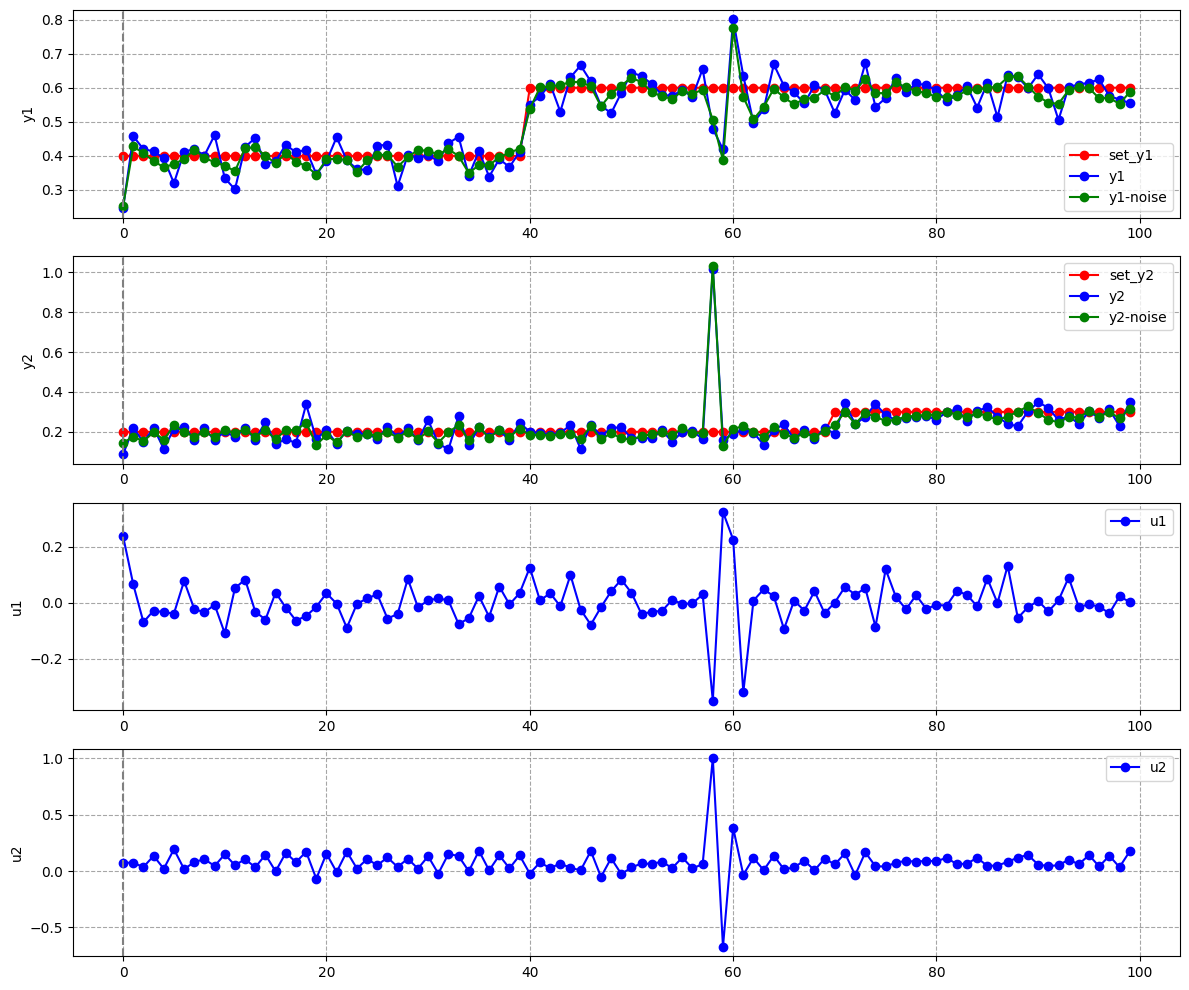

In [73]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 10))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(set_y1, 'ro-', label='set_y1')
plt.plot(np.array(all_pred_y1), 'bo-', label='y1')
plt.plot(np.array(all_pred_y1)-np.array(all_pred_noise1), 'go-', label='y1-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('y1')
# plt.title('Comparison of set_y1 and all_pred_y1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(set_y2, 'ro-', label='set_y2')
plt.plot(np.array(all_pred_y2), 'bo-', label='y2')
plt.plot(np.array(all_pred_y2)-np.array(all_pred_noise2), 'go-', label='y2-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('y2')
# plt.title('Comparison of set_y2 and all_pred_y2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第一个维度的u1曲线
plt.subplot(4, 1, 3)
plt.plot(all_pred_u1, 'bo-', label='u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('u1')
# plt.title('Prediction of all_pred_u1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(4, 1, 4)
plt.plot(all_pred_u2, 'bo-', label='u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
# plt.xlabel('Sample Index')
plt.ylabel('u2')
# plt.title('Prediction of all_pred_u2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()


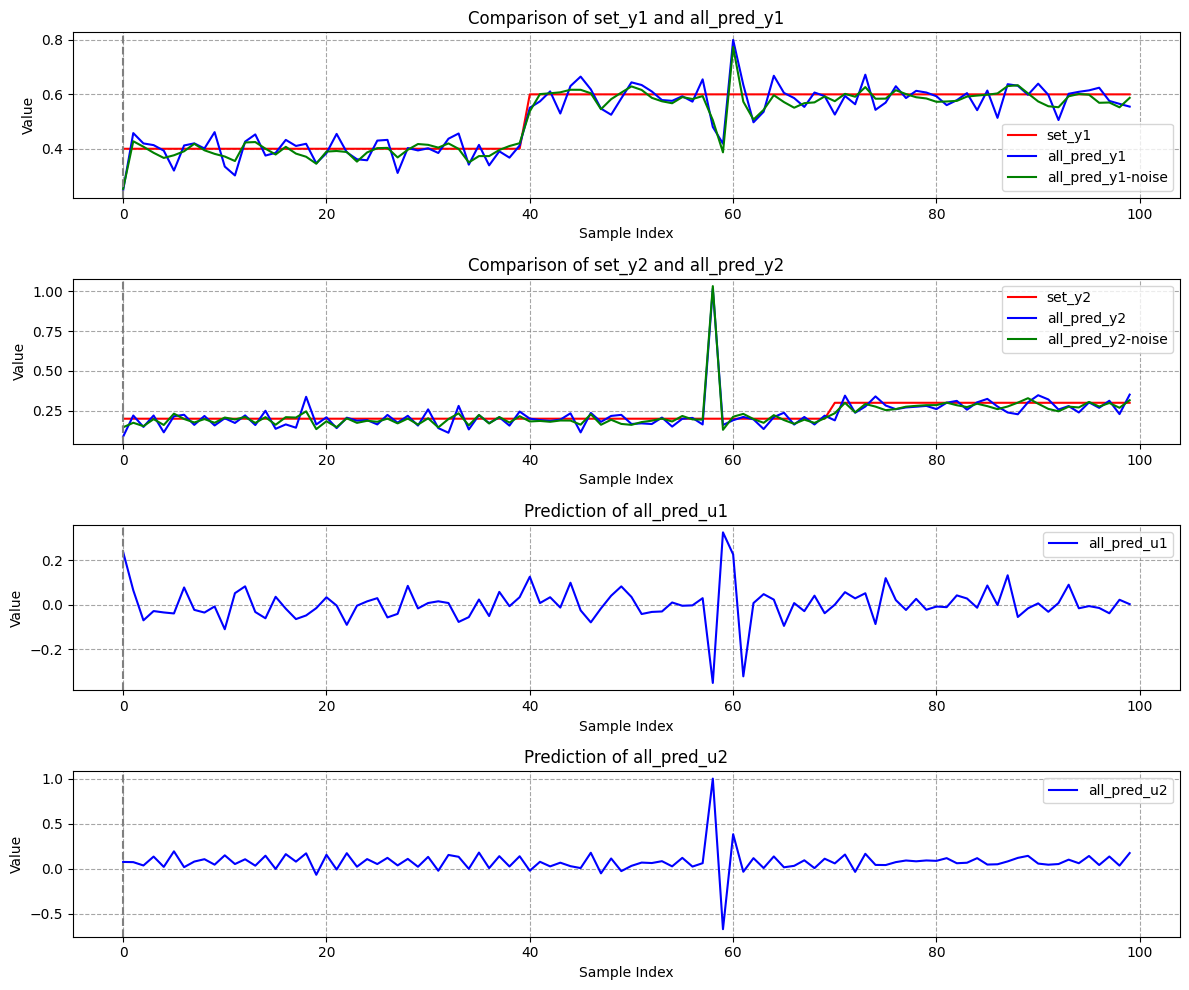

In [74]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
plt.figure(figsize=(12, 10))

# 第一个维度的曲线
plt.subplot(4, 1, 1)
plt.plot(set_y1, 'r-', label='set_y1')
plt.plot(np.array(all_pred_y1), 'b-', label='all_pred_y1')
plt.plot(np.array(all_pred_y1)-np.array(all_pred_noise1), 'g-', label='all_pred_y1-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y1 and all_pred_y1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的曲线
plt.subplot(4, 1, 2)
plt.plot(set_y2, 'r-', label='set_y2')
plt.plot(np.array(all_pred_y2), 'b-', label='all_pred_y2')
plt.plot(np.array(all_pred_y2)-np.array(all_pred_noise2), 'g-', label='all_pred_y2-noise')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Comparison of set_y2 and all_pred_y2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第一个维度的u1曲线
plt.subplot(4, 1, 3)
plt.plot(all_pred_u1, 'b-', label='all_pred_u1')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u1')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 第二个维度的u2曲线
plt.subplot(4, 1, 4)
plt.plot(all_pred_u2, 'b-', label='all_pred_u2')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Prediction of all_pred_u2')
plt.legend()
plt.grid(linestyle='--', alpha=0.7, color='gray')

# 调整子图布局
plt.tight_layout()
plt.show()
